In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
act = pd.read_csv('data/atusact_2014.dat')
cps = pd.read_csv('data/atuscps_2014.dat')
resp = pd.read_csv('data/atusresp_2014.dat')
rost = pd.read_csv('data/atusrost_2014.dat')
rostec = pd.read_csv('data/atusrostec_2014.dat')
sum_ = pd.read_csv('data/atussum_2014.dat') \
                  .rename(columns={'tucaseid':'TUCASEID'})
who = pd.read_csv('data/atuswho_2014.dat')
ind_codes = pd.read_csv('ind_codes.csv', sep="|")
acts = pd.read_excel('data/lexiconwex2014.xls', 1, header=1, parse_cols=1) \
                    .rename(columns={'6-digit activity code' : 'TRCODE',
                                     'Activity' : 'activity'}).dropna()

## What percent of part-time employees are also students? 
## What percent of students are also employed?
 - resp 
     - TESCHENR - are you enrolled in high school, college, or university? 
         - (1 - Yes, 2 - No)
     - TELFS - Edited: labor force status
         - (1 - Employed - at work, 2 - Employed - absent, 3 - Unemployed - on layoff, 4 - Unemployed - looking, 5 - Not in labor force)
     - TEHRFTPT - do you usually work more than 35 hours per week at your Respondent File job(s)/family business? 
         - (1 - Yes, 2 - No, 3 - Hours Vary)
     - TESPEMPNOT - Edited: employment status of spouse or unmarried partner
         - (1 - Employed, 2 - Unemployed)
     - TRDPFTPT - Full time or part time employment status of respondent
         - (1 - Full time, 2 - Part time)
     - TRSPFTPT - Full time or part time employment status of spouse or unmarried partner
         - (1 - Full time, 2 - Part time)
     - TESCHFT - Edited: are you enrolled as a full-time or part-time student?
         - (1 - Full time, 2 - Part time)

In [3]:
studies_v_work = resp[['TUCASEID', 'TESCHENR', 'TESCHFT', 'TELFS', 'TEHRFTPT', 
                       'TESPEMPNOT', 'TRDPFTPT', 'TRSPFTPT']] \
      .rename(columns={'TESCHENR' : 'enrolled', 'TELFS' : 'status', 
                       'TEHRFTPT' : 'hours', 'TESPEMPNOT' : 'spouse_emp', 
                       'TRDPFTPT' : 'full', 'TRSPFTPT' : 'spouse-full',
                       'TESCHFT' : 'full-student'})
students = studies_v_work[studies_v_work['enrolled'] == 1]
students['status'].value_counts()/len(students)

1    0.463783
5    0.398390
4    0.096579
2    0.034205
3    0.007042
dtype: float64

#### Employed students

From this data, if we sum the percentages for values 1 (Employed - at work) and 2 (Employed - absent), we see that approximately **49.8%** of students are also employed.  From here, let's see what percent of these employed students are working full-time jobs.

In [4]:
students['full'][students['status'] < 2] \
        .value_counts()/len(students[students['status'] < 2])

1    0.533623
2    0.466377
dtype: float64

#### Students employed full-time

Here we see that **53.4%** of employed students work full-time jobs, with part-time jobs bringing up the other 46.6%.  Out of curiousity, let's go back and see what percentage of unemployed students have employed spouses.

In [5]:
students['spouse_emp'][students['status'] > 1] \
        .value_counts()/len(students[students['status'] > 1])

-1    0.853659
 1    0.125704
 2    0.020638
dtype: float64

#### Employed spouses of students
Finally, we see that **12.6%** of our unemployed students have employed spouses

## Is there a relationship between weekly wage and care for older/younger relatives?
 - time spent?
 - in home or otherwise for older?
 - time spent working vs. time spent 
 
 - resp
     - TRERNWA - Weekly earnings at main job (2 implied decimals)
         - 0 - 288461 (in cents)
     - TRTEC - Total time spent providing eldercare (in minutes)
         - 0 - 1440 (in minutes)
     - TRTEC_LN - Time spent providing eldercare by activity (in minutes)
         - 0 - 1440 (in minutes)
         - Note: Excludes time spent in activities with codes = 01xxxx or 0805xx
     - TEHRUSLT - Edited: total hours usually worked per week (sum of TEHRUSL1 and Respondent File, TEHRUSL2)
         - 0 - 999 (in hours)
         - -4 (Hours vary)
     - TULINENO - ATUS person line number
         - 0 - 30
 - rostec
     - TRELHH - Eldercare recipient is a household member
         - (0 - Recipient is not a household member, 1 - Recipient is a household member)
     - TULINENO - ATUS person line number
         - 0 - 30

In [6]:
elder_care = resp[['TUCASEID', 'TRERNWA', 'TRTEC', 'TEHRUSLT']] \
                .rename(columns={'TUCASEID': 'case_id', 'TRERNWA' : 'wages',
                                 'TRTEC': 'care_time', 
                                 'TEHRUSLT' : 'work_time'})
elder_care = elder_care[elder_care.care_time > 0]
elder_care = elder_care[elder_care.wages > 0]
elder_care.corr()

,case_id,wages,care_time,work_time
case_id,1.000000,-0.035301,0.032763,-0.016667
wages,-0.035301,1.000000,0.048380,0.349187
care_time,0.032763,0.048380,1.000000,0.141882
work_time,-0.016667,0.349187,0.141882,1.000000


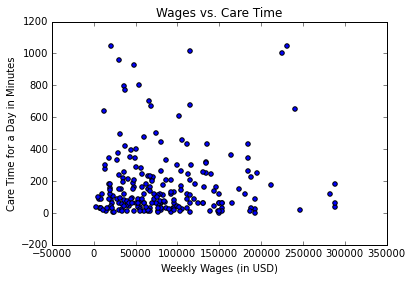

In [7]:
elder_care.plot('wages', 'care_time', kind='scatter', 
                title="Wages vs. Care Time")
plt.xlabel('Weekly Wages (in USD)')
plt.ylabel('Care Time for a Day in Minutes')
plt.show()

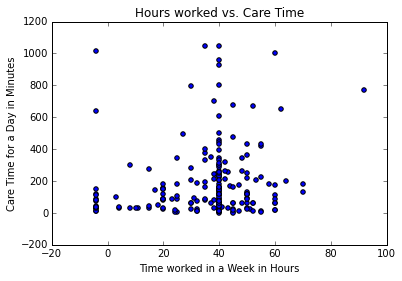

In [8]:
elder_care.plot('work_time', 'care_time', kind='scatter',
                title="Hours worked vs. Care Time")
plt.xlabel('Time worked in a Week in Hours')
plt.ylabel('Care Time for a Day in Minutes')
plt.show()

#### Wages and work hours compared to time spent caring for the elderly
Based on the data we have here, there is **no strong correlation** between time spent caring for the elderly and wages earned or hours worked.  From our Pearson correlations, we get almost as strong a correlation of care time to case ID as we do care time to wages.  The strongest correlation (aside from work time to wages) is a slight one between care time and work time at a positive .1419.

# TRTO_LN

## Industry worked vs. anything?

In [9]:
merged = pd.merge(pd.merge(pd.merge(act, cps), pd.merge(resp, rost))
         , pd.merge(pd.merge(rostec, sum_), who))

## Various activities across prescence of spouse, partner, neither
- resp
    - TRSPPRES - Presence of the respondent's spouse or unmarried partner in the Respondent File, household
        - (1 - Spouse present, 2 - Unmarried partner present, 3 - No spouse or unmarried partner present)
- act
    - all

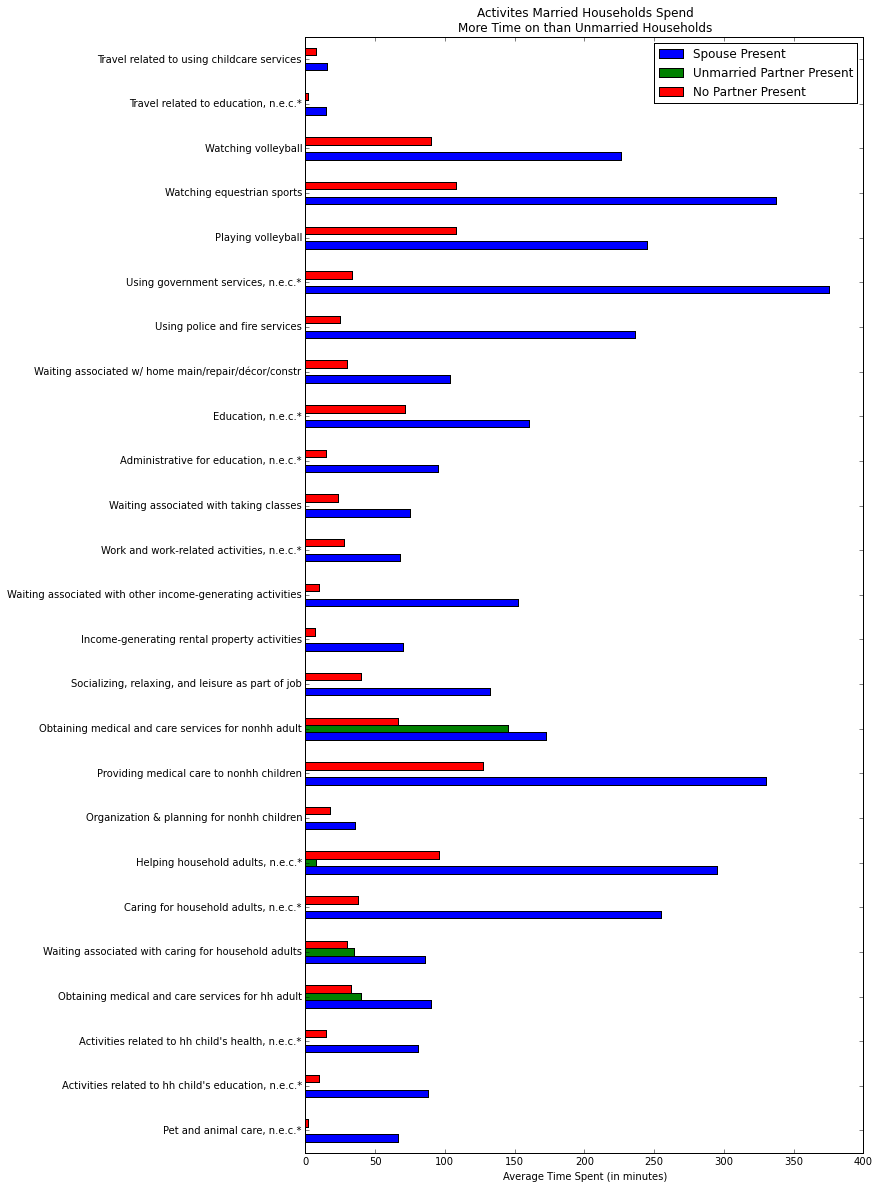

In [10]:
married_life = pd.merge(resp[['TUCASEID', 'TRSPPRES']], 
                        act[['TUCASEID', 'TRCODE', 'TUACTDUR']])
married_means = married_life.groupby(['TRCODE', 'TRSPPRES']) \
                            .agg({'TUACTDUR' : np.mean}).unstack()
acts.index = acts.TRCODE
married_means.index = (acts.loc[str(idx).rjust(6, '0')][1]
                       for idx in married_means.index)
married_means.index
married_gains = married_means[married_means.icol(0) > 
                              2*married_means.icol(2)]
married_losses = married_means[married_means.icol(0)*2 < 
                               married_means.icol(2)]
married_gains.plot(kind="barh", figsize=(10, 20), 
                   title='Activites Married Households Spend\n'
                         'More Time on than Unmarried Households')
plt.xlabel('Average Time Spent (in minutes)')
plt.legend(['Spouse Present', 'Unmarried Partner Present', 
            'No Partner Present'])
plt.show()

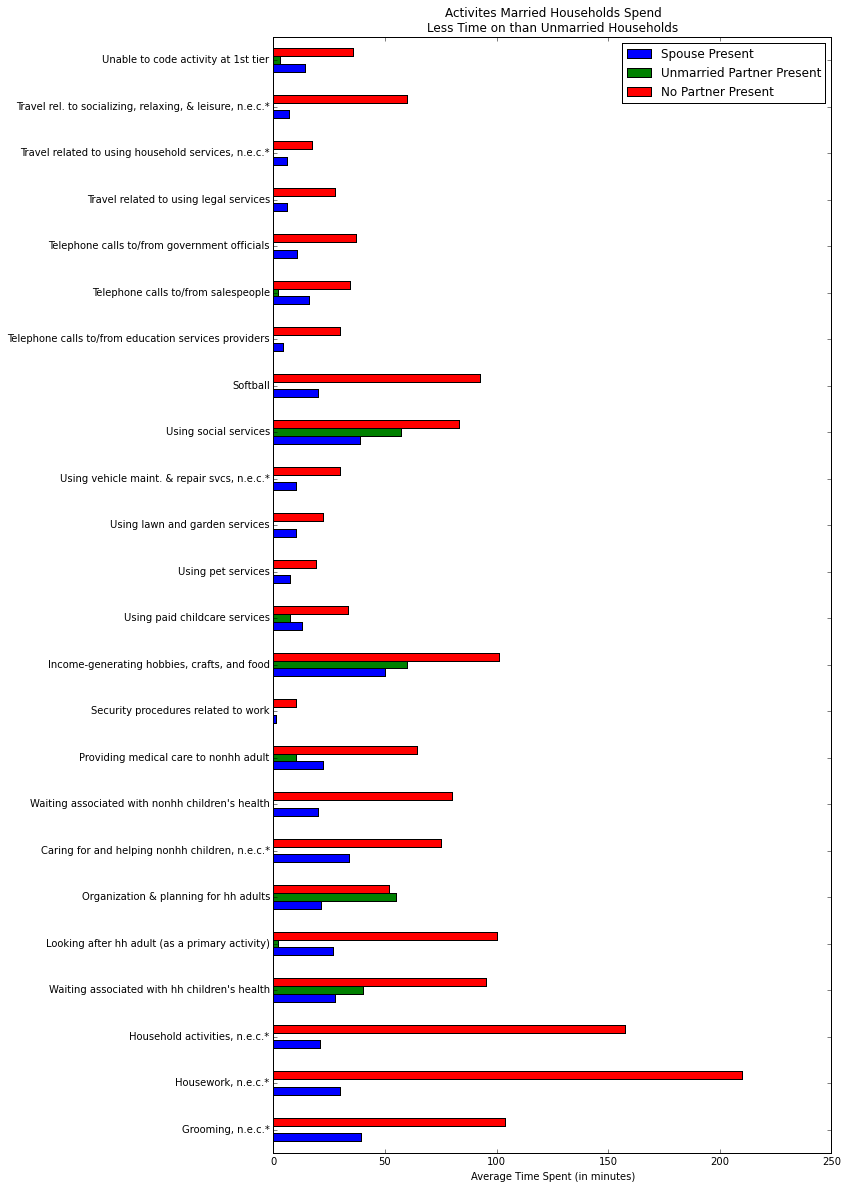

In [11]:
married_losses.plot(kind="barh", figsize=(10, 20),
                   title='Activites Married Households Spend\n'
                         'Less Time on than Unmarried Households')
plt.legend(['Spouse Present', 'Unmarried Partner Present', 
            'No Partner Present'])
plt.xlabel('Average Time Spent (in minutes)')
plt.show()

#### Living with spouse vs. without
A lot of the changes found could be expected.  Those households that contained a married couple saw less time spent on activities relating to the home and those involving household adults, household children, and non-household children.  

I found several points interesting from the data.  Since means graphed here only represent households that reported doing the activity, they could possibly be investigated for issues with sample size.
    - People living with spouses spent more time associated with obtaining care and medical services for 
    non-household adults.
    - Married households reported longer times spent on playing volleyball, watching volleyball, and 
    watching equestrian sports
    - Households without spouses reported longer times spent on softball
    - Time spent organizing and planning saw a higher average time from spouseless households with a slight 
    increase for unmarried partners, and then a more than 50% drop for households with spouses
    - Grooming was perhaps not a surprise in the change in time spent between households with and without 
    spouses, but the average being over 100 minutes leads me to be curious about the range of reported times.

## Time spent with work acquaintances outside of work for various industries
- resp
    - TRTCCC - Total nonwork-related time respondent spent with customers, clients, and Respondent File coworkers (in minutes)
         - 
    - TEHRUSLT - Edited: total hours usually worked per week (sum of TEHRUSL1 and Respondent File, TEHRUSL2)
         - 0 - 999 (in minutes)
